In [1]:
# This file plays the mpc motion only in viz
%load_ext autoreload
%autoreload 2

import time
import numpy as np
import pinocchio as pin
import crocoddyl
from matplotlib import pyplot as plt
%matplotlib notebook 

from py_biconvex_mpc.motion_planner.cpp_biconvex import BiConvexMP
from inverse_kinematics_cpp import InverseKinematics
from py_biconvex_mpc.ik_utils.gait_generator import GaitGenerator
from robot_properties_solo.config import Solo12Config

solo import 


In [2]:
robot = Solo12Config.buildRobotWrapper()
rmodel = robot.model
rdata = robot.data
viz = pin.visualize.MeshcatVisualizer(robot.model, robot.collision_model, robot.visual_model)
viz.initViewer(open=False)
viz.loadViewerModel()
pin_robot = Solo12Config.buildRobotWrapper()
urdf = Solo12Config.urdf_path


q0 = np.array(Solo12Config.initial_configuration)
v0 = pin.utils.zero(pin_robot.model.nv)
x0 = np.concatenate([q0, pin.utils.zero(pin_robot.model.nv)])
x_reg = x0

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7003/static/


In [3]:
eff_names = ["FL_FOOT", "FR_FOOT", "HL_FOOT", "HR_FOOT"]
hip_names = ["FL_HFE", "FR_HFE", "HL_HFE", "HR_HFE"]
pin.forwardKinematics(rmodel, rdata, q0, np.zeros(rmodel.nv))
pin.updateFramePlacements(rmodel, rdata)
com_init = pin.centerOfMass(rmodel, rdata, q0, np.zeros(rmodel.nv))

ee_frame_id = []
for i in range(len(eff_names)):
    ee_frame_id.append(rmodel.getFrameId(eff_names[i]))

In [4]:
dt = 5e-2
T = 1.5
rt = 0.5
st = 0.5
swing_wt = [1e4, 1e4]
reg_wt = [7e-3, 7e-5]

state_wt = np.array([0., 0, 0] + [100, 0, 100] + 4*[50.0, 50.0, 50] \
                        + [0.00] * 3 + [10, 10, 10] + [0.5] *(pin_robot.model.nv - 6))

state_wt2 = np.array([0., 0, 100.0] + [100, 100, 100] + 4*[50.0, 50.0, 50] \
                        + [0.00] * 3 + [10, 10, 10] + [0.5] *(pin_robot.model.nv - 6))

x_reg2 = x_reg.copy()
x_reg2[3:7] = [0,1,0,0]

x_reg2[7:13] = 2 * [0.0, -np.pi + 0.8, -1.6]
x_reg2[13:19] = 2 * [0.0, np.pi - 0.8, 1.6]


state_wt3 = np.array([0., 0, 0.0] + [100, 100, 100] + 4*[50.0, 50.0, 50.0] \
                        + [0.00] * 3 + [10, 10, 10] + [0.5] *(pin_robot.model.nv - 6))

x_reg3 = x_reg.copy()
x_reg3[7:13] = 2 * [0.0, -np.pi/2 + 0.8, -1.6]
x_reg3[13:19] = 2 * [0.0, np.pi/2 - 0.8, 1.6]
x_reg3[3:7] = [0,0.7071,0,0.7071]

ctrl_wt = [0, 0, 10] + [1, 1, 1] + [5.0] *(pin_robot.model.nv - 6)


cnt_plan = [[[ 1.,      0.3946,   0.14695,  0., 0.,  st    ],
             [ 1.,      0.3946,  -0.14695,  0., 0.,  st    ],
             [ 1.,      0.0054,   0.14695,  0., 0.,  st    ],
             [ 1.,      0.0054,  -0.14695,  0., 0.,  st    ]],

            [[ 1.,      0.3946,   0.14695,  0., st, st + rt   ],
             [ 1.,      0.3946,  -0.14695,  0., st, st + rt   ],
             [ 0.,      0.0054,   0.14695,  0., st, st + rt   ],
             [ 0.,      0.0054,  -0.14695,  0., st, st + rt   ]],

            [[ 1.,      0.3946,   0.14695,  0., st + rt, T    ],
             [ 1.,      0.3946,  -0.14695,  0., st + rt, T    ],
             [ 1.,      0.9054,   0.14695,  0., st + rt, T    ],
             [ 1.,      0.9054,  -0.14695,  0., st + rt, T    ]]]

In [5]:
ik = InverseKinematics(urdf, dt, T)
ik.setup_costs()

for i in range(int(T/dt)):
    t = i*dt
    for j in range(len(eff_names)):
        if t < st:
            pos = cnt_plan[0][j][1:4]
            ik.add_position_tracking_task_single(ee_frame_id[j], pos, swing_wt[0],
                                                              "cnt_" + str(0) + eff_names[j], i)
        elif t >= st and t < st + rt:
            if cnt_plan[1][j][0] == 1:
                pos = cnt_plan[1][j][1:4]
                ik.add_position_tracking_task_single(ee_frame_id[j], pos, swing_wt[0],
                                                                  "cnt_" + str(0) + eff_names[j], i)
        
        elif t >= st + rt and t < T:
            pos = cnt_plan[2][j][1:4]
            ik.add_position_tracking_task_single(ee_frame_id[j], pos, swing_wt[0],
                                                              "cnt_" + str(0) + eff_names[j], i)

ik.add_state_regularization_cost(0, st, reg_wt[0], "xReg", state_wt, x_reg, False)
ik.add_state_regularization_cost(st, st + rt, reg_wt[0], "xReg", state_wt3, x_reg3, False)
ik.add_state_regularization_cost(st+rt, T, reg_wt[0], "xReg", state_wt2, x_reg2, False)

# ik.add_state_regularization_cost(st+rt, T, 1e5*reg_wt[0], "xReg", state_wt2, x_reg2, True)
ik.add_ctrl_regularization_cost_2(0, T, reg_wt[1], "uReg", ctrl_wt, np.zeros(rmodel.nv), True)

In [6]:
ik.optimize(x0)

xs = ik.get_xs()
us = ik.get_us()



breaking outer loop due to norm ...
Maximum iterations reached 
Final norm: 0.000981726


<IPython.core.display.Javascript object>


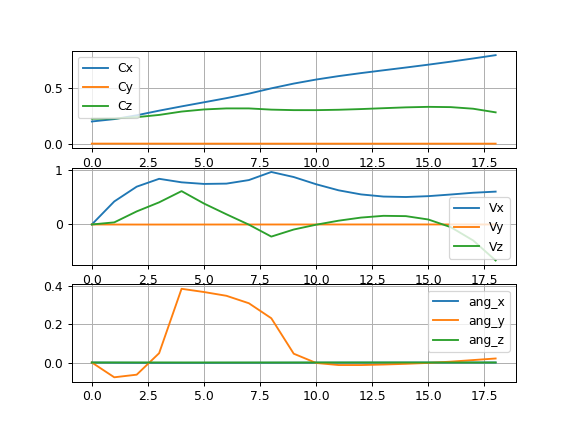

<IPython.core.display.Javascript object>


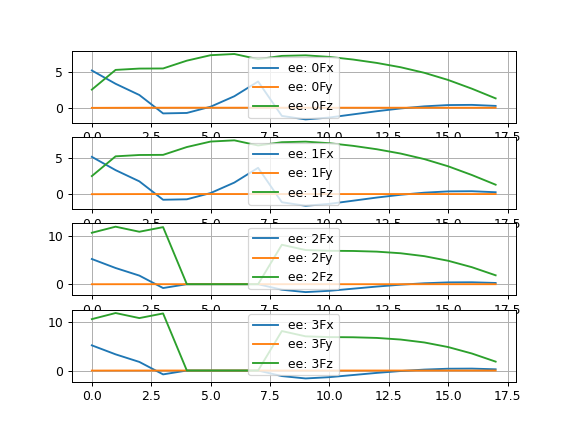

In [78]:
## Demo for robot doing a cartwheel 
## Author : Avadesh Meduri
## Date : 04/08/2021

import time
import numpy as np
import pinocchio as pin
import crocoddyl
from matplotlib import pyplot as plt

from py_biconvex_mpc.motion_planner.cpp_biconvex import BiConvexMP
from inverse_kinematics_cpp import InverseKinematics
from py_biconvex_mpc.ik_utils.gait_generator import GaitGenerator
from robot_properties_solo.config import Solo12Config

robot = Solo12Config.buildRobotWrapper()
rmodel = robot.model
rdata = robot.data

pin_robot = Solo12Config.buildRobotWrapper()
urdf = Solo12Config.urdf_path


q0 = np.array(Solo12Config.initial_configuration)
v0 = pin.utils.zero(pin_robot.model.nv)
x0 = np.concatenate([q0, pin.utils.zero(pin_robot.model.nv)])
x_reg = x0

eff_names = ["FL_FOOT", "FR_FOOT", "HL_FOOT", "HR_FOOT"]
hip_names = ["FL_HFE", "FR_HFE", "HL_HFE", "HR_HFE"]
pin.forwardKinematics(rmodel, rdata, q0, np.zeros(rmodel.nv))
pin.updateFramePlacements(rmodel, rdata)
com_init = pin.centerOfMass(rmodel, rdata, q0, np.zeros(rmodel.nv))

ee_frame_id = []
for i in range(len(eff_names)):
    ee_frame_id.append(rmodel.getFrameId(eff_names[i]))

dt = 5e-2
T = 0.9
rt = 0.2
st = 0.2

swing_wt = [1e4, 1e3]
reg_wt = [1e-2, 7e-5]

state_wt = np.array([0., 0, 0] + [100, 0, 100] + 4*[50.0, 50.0, 50] \
                        + [0.00] * 3 + [10, 10, 10] + [3.5] *(pin_robot.model.nv - 6))

state_wt2 = np.array([0., 0, 1000.0] + [100, 100, 100] + 4*[50.0, 50.0, 50] \
                        + [0.00] * 3 + [10, 10, 10] + [3.5] *(pin_robot.model.nv - 6))

x_reg2 = x_reg.copy()
x_reg2[3:7] = [0,1,0,0]

x_reg2[7:13] = 2 * [0.0, -np.pi + 0.8, -1.6]
x_reg2[13:19] = 2 * [0.0, np.pi - 0.8, 1.6]


state_wt3 = np.array([0., 0, 0.0] + [10, 10, 10] + 4*[50.0, 50.0, 50.0] \
                        + [0.00] * 3 + [10, 10, 10] + [3.5] *(pin_robot.model.nv - 6))

x_reg3 = x_reg.copy()
x_reg3[7:13] = 2 * [0.0, -np.pi/2 + 0.8, -1.6]
x_reg3[13:19] = 2 * [0.0, np.pi/2 - 0.8, 1.6]
x_reg3[3:7] = [0,0.7071,0,0.7071]

ctrl_wt = [0, 0, 10] + [1, 1, 1] + [50.0] *(pin_robot.model.nv - 6)



cnt_plan = [[[ 1.,      0.3946,   0.14695,  0., 0.,  st    ],
             [ 1.,      0.3946,  -0.14695,  0., 0.,  st    ],
             [ 1.,      0.0054,   0.14695,  0., 0.,  st    ],
             [ 1.,      0.0054,  -0.14695,  0., 0.,  st    ]],

            [[ 1.,      0.3946,   0.14695,  0., st, st + rt   ],
             [ 1.,      0.3946,  -0.14695,  0., st, st + rt   ],
             [ 0.,      0.0054,   0.14695,  0., st, st + rt   ],
             [ 0.,      0.0054,  -0.14695,  0., st, st + rt   ]],

            [[ 1.,      0.3946,   0.14695,  0., st + rt, T    ],
             [ 1.,      0.3946,  -0.14695,  0., st + rt, T    ],
             [ 1.,      0.9054,   0.14695,  0., st + rt, T    ],
             [ 1.,      0.9054,  -0.14695,  0., st + rt, T    ]]]

m = pin.computeTotalMass(rmodel)

bx = 0.15
by = 0.15
bz = 0.45
fx_max = 25
fy_max = 25
fz_max = 25

W_X =        np.array([1e-2, 1e-2, 1e+5, 1e-2, 1e-2, 1e-4, 1e+3, 1e+4, 1e+4])
W_X_ter = 10*np.array([1e+2, 1e-2, 1e+5, 1e-2, 1e-2, 1e-4, 1e+3, 1e+3, 1e+4])
W_F = np.array(4*[1e+1, 1e+1, 1e+1])
nom_ht  = [0.6, 0, 0.3]
rho = 5e+4


for l in range(1):

    mp = BiConvexMP(m, dt, T, len(eff_names), rho = rho)

    X_init = np.zeros(9)
    pin.computeCentroidalMomentum(rmodel, rdata)
    X_init[0:3] = pin.centerOfMass(rmodel, rdata, q0, v0)
    X_init[3:] = np.array(rdata.hg)
    X_init[3:6] /= m

    X_nom = np.zeros((9*int(T/dt)))
    X_nom[9*(int(0.5*st/dt)) + 2::9] = nom_ht[2]
    X_nom[9*(int(st/dt)) + 7::9] = 0.5
    X_nom[9*(int((st + rt)/dt)) + 7::9] = 0.0
    
    
    X_ter = np.zeros_like(X_init)
    X_ter[2] = 0.3
    X_ter[0] = 0.6
    
    mp.create_contact_array(np.array(cnt_plan))
    mp.create_bound_constraints(bx, by, bz, fx_max, fy_max, fz_max)
    mp.create_cost_X(W_X, W_X_ter, X_ter, X_nom)
    mp.create_cost_F(W_F)

    if l > 0:
        opt_mom = np.zeros((len(xs), 6))
        opt_com = np.zeros((len(xs), 3))
        m = pin.computeTotalMass(rmodel)
        for i in range(len(xs)):
            q = xs[i][:rmodel.nq]
            v = xs[i][rmodel.nq:]
            pin.forwardKinematics(rmodel, rdata, q, v)
            pin.computeCentroidalMomentum(rmodel, rdata)
            opt_com[i] = pin.centerOfMass(rmodel, rdata, q, v)
            opt_mom[i] = np.array(rdata.hg)
            opt_mom[i][0:3] /= m

        mp.add_ik_com_cost(opt_com)
        mp.add_ik_momentum_cost(opt_mom)

    com_opt, F_opt, mom_opt = mp.optimize(X_init, 150)

    
    ik = InverseKinematics(urdf, dt, T)
    
    ik.add_com_position_tracking_task(0, T, com_opt, 1, "com", False)
    ik.add_centroidal_momentum_tracking_task(0, T, mom_opt, 1e2, "mom", False)

    for i in range(int(T/dt)):
        t = i*dt
        for j in range(len(eff_names)):
            if t < st:
                pos = cnt_plan[0][j][1:4]
                ik.add_position_tracking_task_single(ee_frame_id[j], pos, swing_wt[0],
                                                                "cnt_" + str(0) + eff_names[j], i)
            elif t >= st and t < st + rt:
                if cnt_plan[1][j][0] == 1:
                    pos = cnt_plan[1][j][1:4]
                    ik.add_position_tracking_task_single(ee_frame_id[j], pos, swing_wt[0],
                                                                    "cnt_" + str(0) + eff_names[j], i)

            elif t >= st + rt and t < T:
                pos = cnt_plan[2][j][1:4]
                ik.add_position_tracking_task_single(ee_frame_id[j], pos, swing_wt[0],
                                                                "cnt_" + str(0) + eff_names[j], i)

    ik.add_state_regularization_cost(0, st, reg_wt[0], "xReg", state_wt, x_reg, False)
    ik.add_state_regularization_cost(st, st + rt, reg_wt[0], "xReg", state_wt3, x_reg3, False)
    ik.add_state_regularization_cost(st+rt, T, reg_wt[0], "xReg", state_wt2, x_reg2, False)

    ik.add_ctrl_regularization_cost_2(0, T, reg_wt[1], "uReg", ctrl_wt, np.zeros(rmodel.nv), True)

    ik.setup_costs()
    ik.optimize(x0)
    xs = ik.get_xs()
    us = ik.get_us()

    if l > -1:
        mp.stats()

In [18]:
viz.viewer.jupyter_cell()

In [83]:
for ind in range(len(xs)):    
    time.sleep(0.1)
    viz.display(xs[ind][:rmodel.nq])


In [10]:
print(xs[-1][3:7])

[ 9.21243019e-04  9.92254162e-01 -1.49962405e-03  1.24211840e-01]
